# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# Load data
file_train = 'https://drive.google.com/uc?id=1r3peideJK2uQ5mV1y_Yp10-IN9rQNxCI'
df = pd.read_excel(file_train)

# df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

The data contains .... rows and ... columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
# Check missing value
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value

df = df[df["CustomerID"].notna()]

df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


Then we could do some descriptive statistic.

In [ ]:


df.info ()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


Yang bisa masuk ke statistic unitprice & quantity

In [ ]:
# Simple descriptive statistic

df [['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data (Ada berapa data yg kurang dari 0 untuk quantity dan sama dengan 0 untuk price)
quantity_minus = len (df[df['Quantity'] < 0])
unitprice_zero = len (df[df['UnitPrice'] == 0])

perc_quantity_minus = (quantity_minus / len (df)) * 100
perc_unitprice_zero = (unitprice_zero / len (df)) * 100

print ("The data consists of", str(quantity_minus), "rows of data with quantity less or equal than zero")
print ("About", str(perc_quantity_minus), "% of total data")
print ("The data consists of", str(unitprice_zero), "rows of data with quantity less or equal than zero")
print ("About", str(perc_unitprice_zero), "% of total data")

The data consists of 8905 rows of data with quantity less or equal than zero
About 2.188880340388714 % of total data
The data consists of 40 rows of data with quantity less or equal than zero
About 0.00983214077659164 % of total data


Dikarenakan datanya hanya 2% dan 0,1% dari total bisa dihapus saja data yang anomali

Then just remove those anomaly data

In [ ]:
# Remove anomaly / outliers
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
# Check unique value
df[["InvoiceNo","StockCode","Description", "CustomerID","Country"]].nunique()

,0
InvoiceNo,18532
StockCode,3665
Description,3877
CustomerID,4338
Country,37


There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

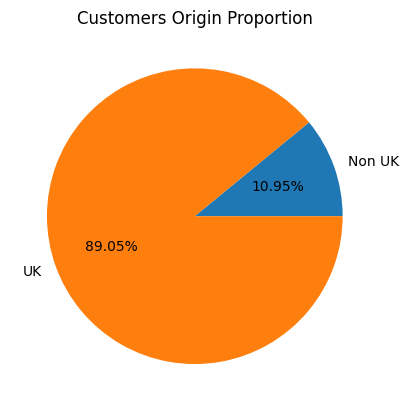

In [ ]:
# Simplify country origin (Pie chart untuk melihat komposisi negara)
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract relevant time features
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Month'] = df['InvoiceDate'].dt.month_name()
df['WeekOfYear'] = df['InvoiceDate'].dt.isocalendar().week

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount,Hour,DayOfWeek,Month,WeekOfYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30,8,Wednesday,December,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,8,Wednesday,December,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00,8,Wednesday,December,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,8,Wednesday,December,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,8,Wednesday,December,48


Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

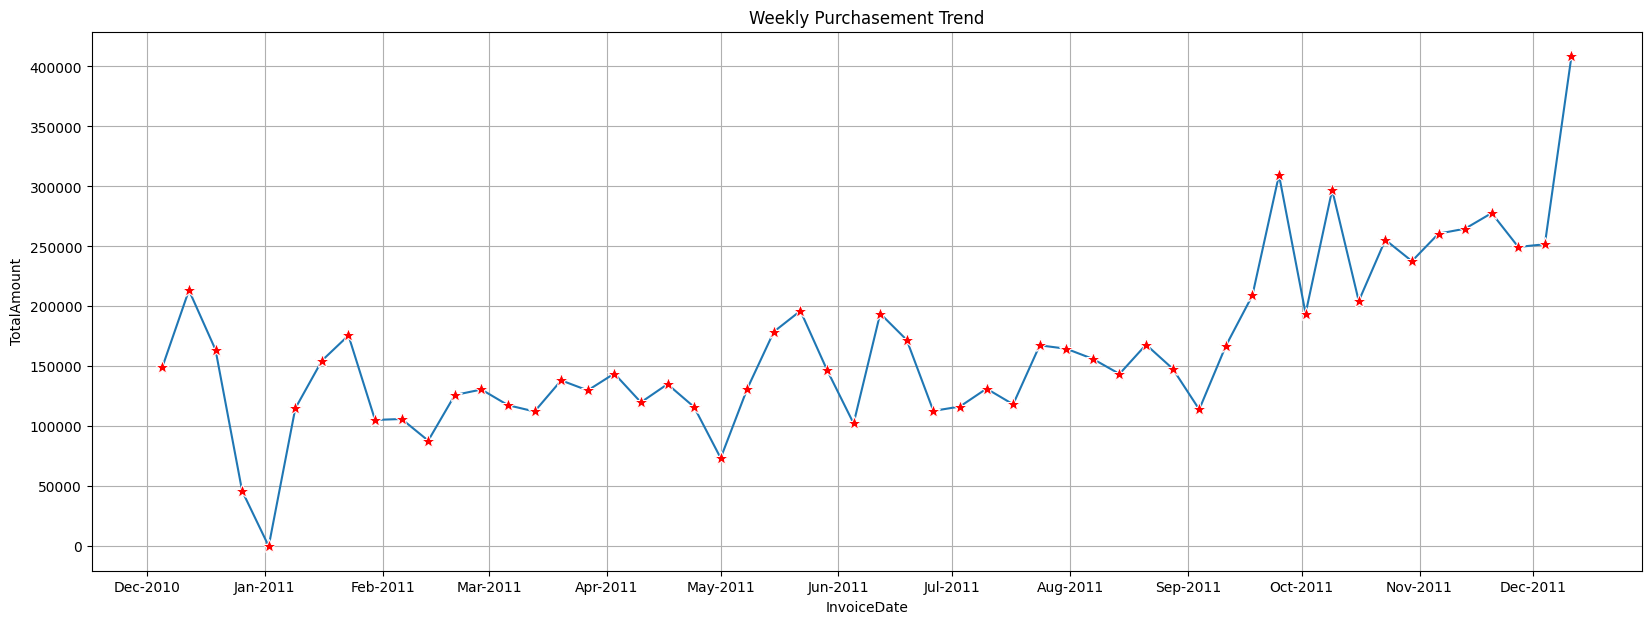

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

<ipython-input-15-5b277a02505f>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()


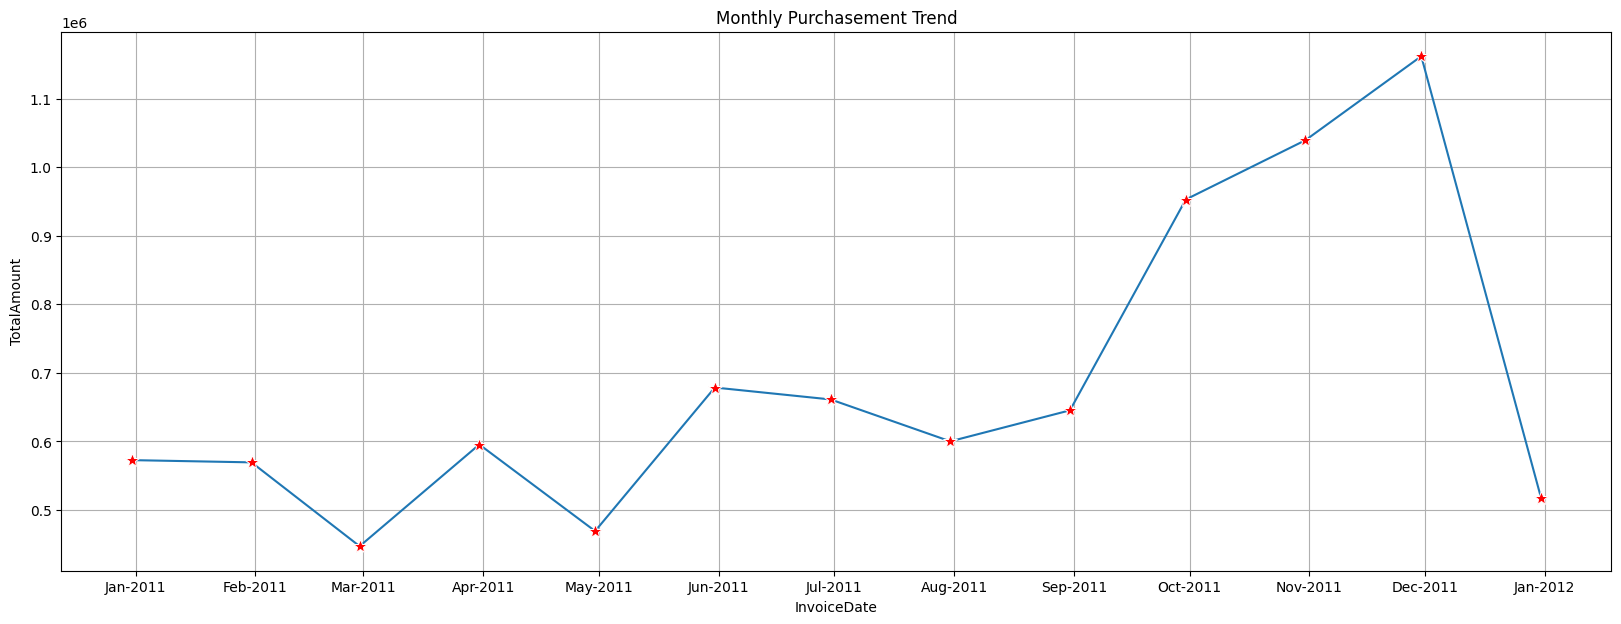

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency ( Tanggal terakhir belanja)

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby (["CustomerID"])["InvoiceDate"].max()
recency = max(recency) - recency
recency = recency.dt.days #Convert to how many days (Berapa hari terakhir belanja)
recency = recency.rename ("Recency")
recency.head()

,Recency
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


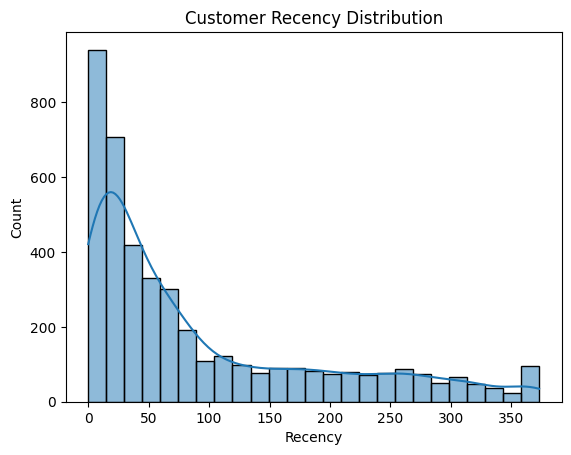

In [ ]:
# Recency histogram plot
plt.title ('Customer Recency Distribution')
sns.histplot(recency, kde=True)
plt.show()

Banyak customer belanja dibawah 50 hari (frekuensinya baik & repetitif), namun mesti dicek pembelian dalam waktu dekat apakah sesuai dengan frekuensi & basket sizenya?

### Frequency (Seberapa sering belanja)

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby (["CustomerID"])["InvoiceNo"].count()
frequency = frequency.rename ("Frequency")
frequency.head()

,Frequency
CustomerID,
12346.0,1
12347.0,182
12348.0,31
12349.0,73
12350.0,17


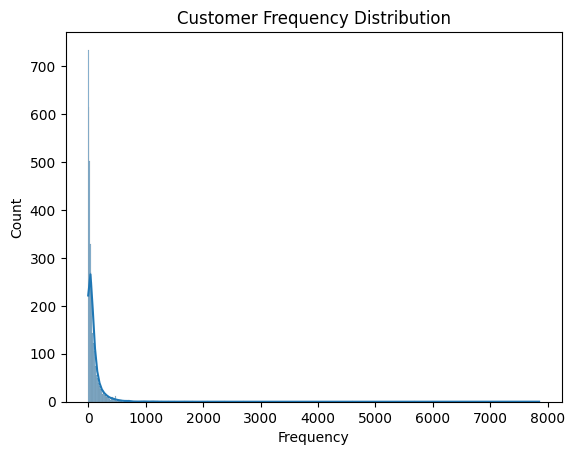

In [ ]:
# Frequency histogram plot
plt.title ('Customer Frequency Distribution')
sns.histplot(frequency, kde=True)
plt.show()

Frekuensi pembelian masih banyak dibawah 1000 kali, meskipun ada sedikit di atas 2000 kali

### Monetary (Basket Size Customer)

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby (["CustomerID"])["TotalAmount"].sum()
monetary = monetary.rename ("Monetary Spent")
monetary.head()

,Monetary Spent
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


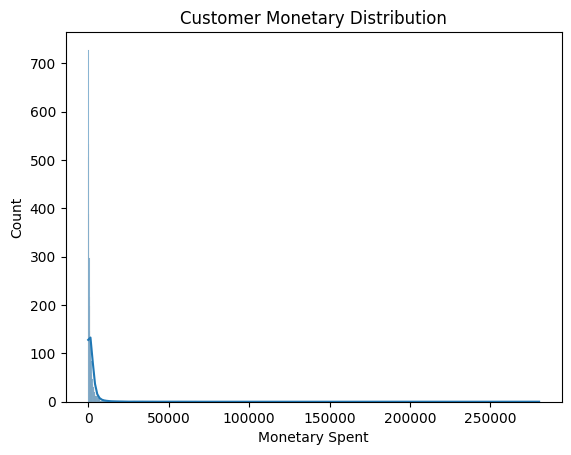

In [ ]:
# Monetary histogram plot
plt.title ('Customer Monetary Distribution')
sns.histplot(monetary, kde=True)
plt.show()

One time buyer tapi spendnya besar, ada yg rutin banyak belanja namun spendingnya kecil (berarti ada sudah ada 2 cluster berbeda)

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method
country.head ()

# Merge the data
df_new = country.merge(recency, on='CustomerID').merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

df_new.head()

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary Spent
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable
df_new = pd.get_dummies (df_new, columns=['Country_isUK'], drop_first=True, dtype=int)
df_new = df_new.rename(columns={'Country_isUK_UK': 'Country_UK'})
df_new.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

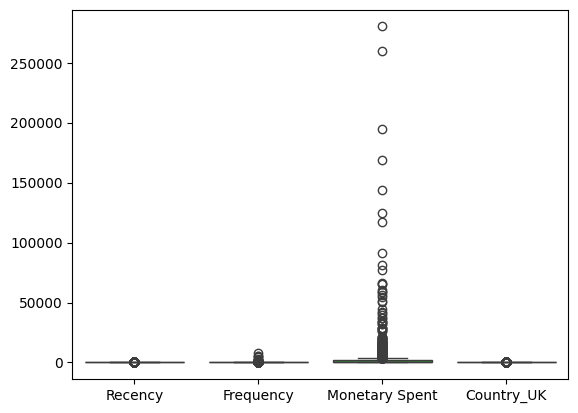

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


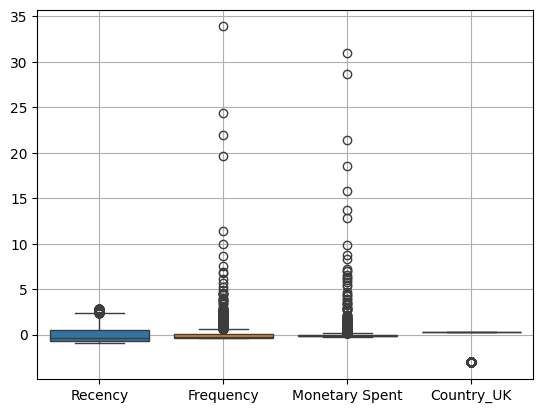

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

# Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

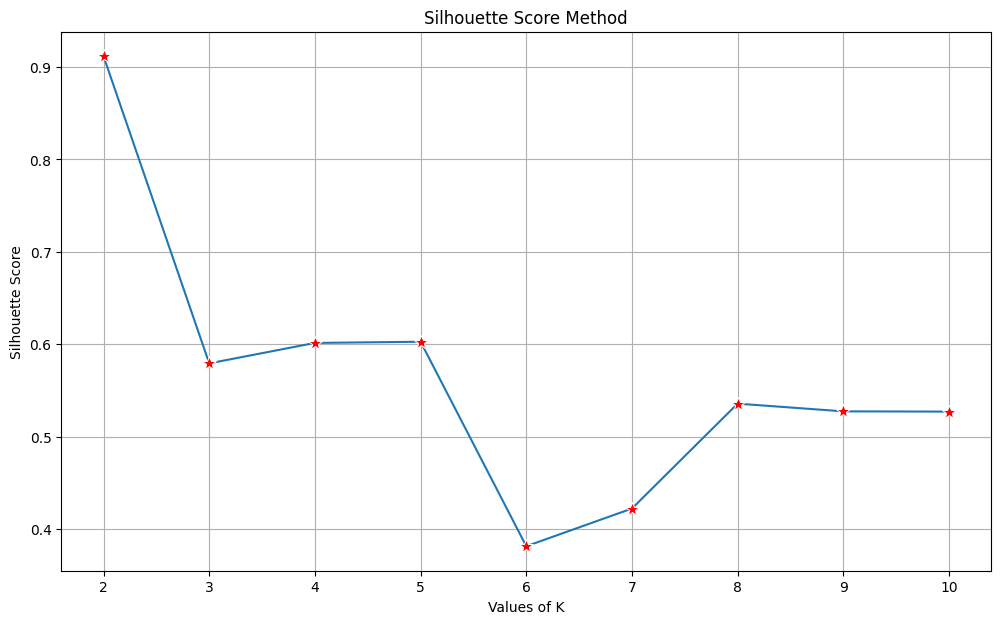

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is 2

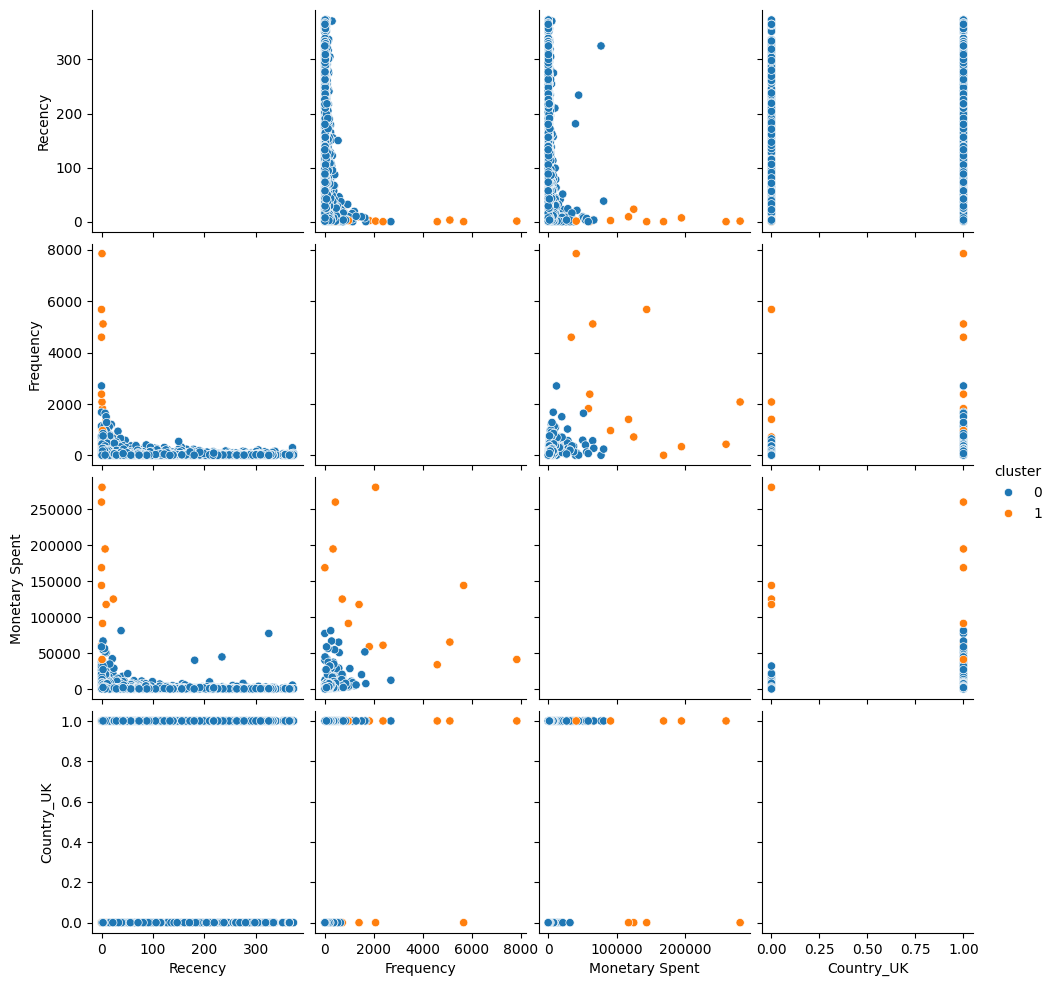

In [ ]:
#Pairplot
kmeans = KMeans(n_clusters=2,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
df_result_kmeans.head()

,Recency,Frequency,Monetary Spent,Country_UK,cluster
CustomerID,,,,,
12346.0,325,1,77183.60,1,0
12347.0,1,182,4310.00,0,0
12348.0,74,31,1797.24,0,0
12349.0,18,73,1757.55,0,0
12350.0,309,17,334.40,0,0


In [ ]:
df_result_kmeans.head()

,Recency,Frequency,Monetary Spent,Country_UK,cluster
CustomerID,,,,,
12346.0,325,1,77183.60,1,0
12347.0,1,182,4310.00,0,0
12348.0,74,31,1797.24,0,0
12349.0,18,73,1757.55,0,0
12350.0,309,17,334.40,0,0


In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                           0              1
Recency        mean       91.800462       3.692308
               std       100.047598       6.459936
               min         0.000000       0.000000
               q25        17.000000       0.000000
               median     50.000000       1.000000
               q75       142.000000       3.000000
               max       373.000000      23.000000
Frequency      mean       84.285549    2565.307692
               std       131.516667    2456.928617
               min         1.000000       3.000000
               q25        17.000000     714.000000
               median     41.000000    1818.000000
               q75        99.000000    4595.000000
               max      2700.000000    7847.000000
Monetary Spent mean     1681.357196  126118.310000
               std      4074.628323   80607.677360
               min         3.750000   33719.730000
               q25       306.940000   60767.900000
               median    669.110000  117379.630000
               q75      1651.030000  168472.500000
               max     81024.840000  280206.020000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        0              414
         1             3911
1        0                4
         1                9
Name: Recency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

cluster  Country_UK
0        0              414
         1             3911
1        0                4
         1                9
Name: Frequency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Monetary Spent"].count()

cluster  Country_UK
0        0              414
         1             3911
1        0                4
         1                9
Name: Monetary Spent, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

#Jawaban Question 1

In [ ]:
# a) Top 5 customers with the most purchases (based on quantity)
top_5_customers = df.groupby('CustomerID')['Quantity'].sum().nlargest(5)
print("Top 5 Customers with the Most Purchases (Quantity):")
print(top_5_customers)
print("\n")

Top 5 Customers with the Most Purchases (Quantity):
CustomerID
14646.0    196915
16446.0     80997
14911.0     80265
12415.0     77374
12346.0     74215
Name: Quantity, dtype: int64




In [ ]:
# b) Time of purchase with the highest number of customers
# (Approximated by the frequency of invoices at different times)
most_popular_hour = df['Hour'].value_counts().idxmax()
most_popular_day = df['DayOfWeek'].value_counts().idxmax()
most_popular_month = df['Month'].value_counts().idxmax()
most_popular_week = df['WeekOfYear'].value_counts().idxmax()

print("Time of Purchase with the Highest Number of Transactions (Approximation for most customers):")
print(f"Hour: {most_popular_hour}")
print(f"Day of the Week: {most_popular_day}")
print(f"Month: {most_popular_month}")
print(f"Week of the Year: {most_popular_week}")
print("\n")

Time of Purchase with the Highest Number of Transactions (Approximation for most customers):
Hour: 12
Day of the Week: Thursday
Month: November
Week of the Year: 48




In [ ]:
# c) Top 5 items with the highest purchase quantity
top_5_items = df.groupby('Description')['Quantity'].sum().nlargest(5)
print("Top 5 Items with the Highest Purchase Quantity:")
print(top_5_items)
print("\n")

Top 5 Items with the Highest Purchase Quantity:
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
Name: Quantity, dtype: int64




In [ ]:
# d) What are the top selling items in the month with the highest purchases?
monthly_purchases = df['Month'].value_counts().sort_values(ascending=False)
highest_purchase_month = monthly_purchases.index[0]

most_popular_items_highest_month = df[df['Month'] == highest_purchase_month]['Description'].value_counts().nlargest(5)

print(f"Month with the Highest Number of Purchases: {highest_purchase_month}")
print(f"Top 5 Most Purchased Items in {highest_purchase_month}:")
print(most_popular_items_highest_month)
print("\n")

Month with the Highest Number of Purchases: November
Top 5 Most Purchased Items in November:
Description
RABBIT NIGHT LIGHT                    466
PAPER CHAIN KIT 50'S CHRISTMAS        359
HOT WATER BOTTLE KEEP CALM            271
PAPER CHAIN KIT VINTAGE CHRISTMAS     240
WHITE HANGING HEART T-LIGHT HOLDER    238
Name: count, dtype: int64




#Jawaban Question 2


## **Rekomendasi Promo untuk Masing-Masing Cluster (Gabungan UK dan Non-UK)**

# **Cluster 0: Pelanggan Pasif & Bernilai Rendah**

**Karakteristik:**

1. Recency (mean: 91.8 hari) → Sudah cukup lama sejak pembelian terakhir.

2. Frequency (mean: 84 transaksi) → Frekuensi belanja relatif rendah.

3. Monetary Spent (mean: 1,681) → Jumlah pembelanjaan sangat kecil.

**Statistik Pendukung:**

1. Q25 dan median Recency cukup besar → sebagian besar pelanggan jarang aktif.

2. Median Monetary hanya 669 → sangat kecil dibanding cluster 1.

3. Penyebaran besar (std tinggi) → cluster ini heterogen, tapi mayoritas tetap tergolong "low value".

**Insight:**

1. Pelanggan ini adalah segmen yang tidak terlalu aktif dan kontribusi ekonominya rendah.

2. Target ideal untuk kampanye reaktivasi, diskon, atau promosi bundle.

**Strategi Promosi:**

1. Kampanye Reaktivasi Multi-Channel

•	Email, WhatsApp, dan Retargeting Ads.

•	Judul yang memicu rasa FOMO dan personal

2. Welcome Back Bundle

•	Paket bundling hemat untuk mengajak mereka belanja kembali.

•	Contoh: “Beli 2 Gratis 1 untuk Kamu yang Lama Tidak Belanja”

3. Voucher Khusus Pelanggan Lama

•	Buat sense of privilege meskipun mereka jarang aktif.

•	Contoh: “Pelanggan Setia Seperti Kamu Layak Dapat Diskon Spesial”

4. Pop-up Diskon dengan Exit-Intent

•	Aktifkan popup saat mereka hendak meninggalkan situs:
“Diskon 10% hanya untuk hari ini! Mau ambil?”

5. Gamifikasi (Spin-to-Win)

•	Hadiah acak seperti diskon, hadiah kecil, atau gratis ongkir untuk mendorong keterlibatan ulang.




# **Cluster 1: Pelanggan Aktif & Bernilai Tinggi**

**Karakteristik: **

1. Recency (mean: 3.7 hari) → Sangat baru melakukan transaksi (aktif).

2. Frequency (mean: 2,565 transaksi) → Sangat sering bertransaksi.

3. Monetary Spent (mean: 126,118) → Pembelanjaan sangat besar.

**Statistik Pendukung:**

1. Median Frequency = 1,818 dan Q3 sampai 4,595 → sangat loyal dan aktif.

2. Monetary Spent sangat tinggi di semua kuartil → konsisten spender besar.

3. Std dev juga tinggi, tapi rentangnya tetap menunjukkan bahwa mayoritas dalam cluster ini adalah pelanggan VIP.

**Insight:**

1. Ini adalah segmen pelanggan paling penting: sangat aktif, loyal, dan bernilai sangat tinggi.

2. Layak diberikan program VIP, personalisasi komunikasi, reward loyalitas, early access produk baru, dll.

3. Harus difokuskan pada strategi retensi, engagement, dan delight.

**Strategi Promosi:**

1. Loyalty & Referral Program

•	Beri poin atas setiap pembelian & bonus referral.

•	Tambahkan reward ekstra untuk pelanggan dari UK atau Non-UK agar tetap
relevan secara geografis.

2. Akses Eksklusif ke Produk Baru / Pre-Order

•	Undang mereka mencoba produk baru lebih dulu.

•	Contoh: “Khusus 500 pelanggan pertama – cicipi produk edisi terbatas!”

3. Personalized Offers

•	Kirim promo berdasar riwayat pembelian:

“Suka Produk A? Coba Produk B dengan diskon 20%”

4. VIP Treatment

•	Kirim ucapan ulang tahun + voucher spesial.

•	Undang ke webinar, demo produk, atau kolaborasi konten (terutama untuk Non-UK jika ingin menjangkau pasar luar).

5. Subscription Plan / Paket Eksklusif

•	Beri pilihan berlangganan atau paket bundle premium.

•	Contoh: “Langganan bulanan: hemat 30% dan dapat bonus tiap pengiriman”



#Jawaban Question 3

In [ ]:
# Filter customer Non-UK
df_non_uk = df[df["Country"] != "United Kingdom"]

# RFM calculation
recency_nuk = df_non_uk.groupby("CustomerID")["InvoiceDate"].max()
recency_nuk = max(recency_nuk) - recency_nuk
recency_nuk = recency_nuk.dt.days
recency_nuk = recency_nuk.rename("Recency")

frequency_nuk = df_non_uk.groupby("CustomerID")["InvoiceNo"].count().rename("Frequency")
monetary_nuk = df_non_uk.groupby("CustomerID")["TotalAmount"].sum().rename("Monetary Spent")

# Gabungkan RFM
df_nuk_rfm = pd.concat([recency_nuk, frequency_nuk, monetary_nuk], axis=1)

# Standarisasi
from sklearn.preprocessing import StandardScaler
scaler_nuk = StandardScaler()
df_nuk_scaled = pd.DataFrame(scaler_nuk.fit_transform(df_nuk_rfm),
                             columns=df_nuk_rfm.columns,
                             index=df_nuk_rfm.index)

# Coba KMeans clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    model = KMeans(n_clusters=k, random_state=42).fit(df_nuk_scaled)
    score = silhouette_score(df_nuk_scaled, model.labels_)
    print(f"K = {k}, Silhouette Score = {score:.3f}")

kmeans_nuk = KMeans(n_clusters=2,random_state=42).fit(df_nuk_scaled)
df_result_kmeans_nuk = df_nuk_rfm.copy()
df_result_kmeans_nuk['cluster'] = kmeans_nuk.labels_

K = 2, Silhouette Score = 0.927
K = 3, Silhouette Score = 0.659
K = 4, Silhouette Score = 0.658
K = 5, Silhouette Score = 0.675


In [ ]:
df_result_kmeans_nuk.head()

,Recency,Frequency,Monetary Spent,cluster
CustomerID,,,,
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0
12352.0,35,85,2506.04,0


In [ ]:

# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans_nuk
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                            0              1
Recency        mean        95.024038       0.500000
               std        104.532139       0.707107
               min          0.000000       0.000000
               q25         18.000000       0.250000
               median      51.500000       0.500000
               q75        135.500000       0.750000
               max        373.000000       1.000000
Frequency      mean        86.086538    3875.500000
               std        119.840344    2544.877305
               min          1.000000    2076.000000
               q25         21.750000    2975.750000
               median      45.000000    3875.500000
               q75        101.000000    4775.250000
               max       1400.000000    5675.000000
Monetary Spent mean      2834.099207  212015.540000
               std       8938.916929   96435.901641
               min         51.560000  143825.060000
               q25        460.150000  177920.300000
               median    1031.195000  212015.540000
               q75       2667.500000  246110.780000
               max     124914.530000  280206.020000

In [ ]:
df_result_kmeans_nuk.shape

(418, 4)

In [ ]:
df_result_kmeans_nuk.groupby(["cluster"])["Recency"].count()

,Recency
cluster,
0,416
1,2


In [ ]:
df_result_kmeans_nuk.groupby(["cluster"])["Frequency"].count()

,Frequency
cluster,
0,416
1,2


In [ ]:
df_result_kmeans_nuk.groupby(["cluster"])["Monetary Spent"].count()

,Monetary Spent
cluster,
0,416
1,2


## **Analisis untuk Non-UK saja**

# **Cluster 0: Low-Value/Inactive Customers**

**Karakteristik:**

•	Recency (mean: 95 hari) → Sudah cukup lama sejak terakhir melakukan transaksi.

•	Frequency (mean: 86 transaksi) → Jumlah transaksi rendah.

•	Monetary Spent (mean: 2,834) → Nilai belanja total sangat rendah.

**Statistik Pendukung:**

•	Banyak pelanggan di cluster ini memiliki frekuensi < 50 dan monetary < 1,000 (lihat Q25 dan median).

•	Std dev besar menunjukkan variabilitas tinggi, tapi sebagian besar customer tetap tergolong tidak aktif dan berbelanja kecil.

**Insight:**

•	Cluster ini merupakan pelanggan yang tidak aktif dan memiliki kontribusi kecil terhadap pendapatan.

•	Mungkin mencakup pelanggan sekali beli, atau yang sudah berhenti melakukan pembelian.

•	Potensi untuk program retensi atau reaktivasi jika biaya akuisisi ulang rendah.

**Strategi Promosi:**

1.	Reaktivasi dengan Diskon Khusus

*   Kampanye email dengan subject seperti: "Kami Rindu Kamu! Nikmati Diskon 20% untuk Kembali Belanja"
*  Time-limited offer untuk menciptakan urgensi.

2.	Free Shipping atau Bonus Produk

* Jika mereka belanja kembali, tawarkan ongkir gratis atau produk tambahan kecil.

3.	Reminder Otomatis & Notifikasi Personal

*	Gunakan notifikasi berbasis waktu (email atau WhatsApp) untuk mengingatkan mereka akan produk yang dulu dibeli.

4.	Rekomendasi Produk Berdasarkan Pembelian Lama

*	“Kamu pernah beli X, mungkin kamu akan suka Y.” → Berikan penawaran eksklusif untuk produk serupa.

5.	Exit-Intent Offer

*	Jika mereka buka website/app lalu hendak keluar, tampilkan popup diskon instan: “Tunggu dulu! Diskon 15% hanya hari ini!”

# **Cluster 1: High-Value/Very Active Customers**

**Karakteristik:**

•	Recency (mean: 0.5 hari) → Sangat baru melakukan pembelian (hampir hari ini).

•	Frequency (mean: 3,875 transaksi) → Jumlah transaksi sangat tinggi.

•	Monetary Spent (mean: 212,015) → Nilai belanja total sangat tinggi.

**Statistik Pendukung:**

•	Median Recency: 0.5, menunjukkan sebagian besar customer di sini sangat aktif (pembelian terakhir baru saja terjadi).

•	Monetary Median = 212,015, dengan Q25 dan Q75 yang juga tinggi → konsisten high spender.

•	Std dev besar, tapi tidak mengubah fakta bahwa semua metrik jauh lebih tinggi dari cluster 0.

**Insight:**

•	Cluster ini berisi pelanggan sangat loyal dan sangat berharga.

•	Mereka sering bertransaksi, belanja dalam jumlah besar, dan baru saja aktif.

•	Sangat ideal untuk loyalty program, up-sell, cross-sell, dan perlu dijaga
engagement-nya.

**Strategi Promosi:**

1.	Loyalty & Rewards Program

*	Berikan poin untuk setiap pembelian, yang bisa ditukar dengan diskon, produk eksklusif, atau hadiah.

*	Contoh: “Setiap pembelian $50 dapat 500 poin. Kumpulkan poin, tukar jadi hadiah!”
2.	Eksklusif Early Access

*	Ajak mereka mencoba produk baru sebelum diluncurkan ke publik.

*	Contoh: “Kamu termasuk pelanggan spesial. Coba menu baru kami sebelum yang lain!”

3.	Personalized Cross-Sell

*	Tawarkan produk pelengkap dari yang mereka sering beli.

*	Contoh: Jika mereka beli sepatu, tawarkan kaus kaki atau perawatan sepatu.

4.	VIP Treatment

*	Kirim ucapan ulang tahun + voucher personal.

*	Ajak ikut event atau challenge khusus pelanggan loyal.

5.	Subscription atau Paket Bundling

*	Tawarkan langganan mingguan/bulanan dengan harga lebih hemat.

*	Contoh: “Langganan 4x pengiriman bulanan, hemat 15%!”



Berdasarkan hasil output dari analisis karakteristik utama dari masing-masing cluster non UK, berikut adalah beberapa kesimpulan yang dapat diambil:

1. Segmentasi pelanggan non-UK menghasilkan dua cluster yang sangat kontras:

* Cluster 0: Pelanggan pasif dan bernilai rendah. Tidak menjadi prioritas kecuali untuk strategi reaktivasi murah.

* Cluster 1: Pelanggan sangat aktif dan bernilai tinggi. Menjadi target utama untuk menjaga loyalitas dan meningkatkan nilai seumur hidup pelanggan (CLV).

2. Perbedaan mencolok dalam recency, frequency, dan monetary membuat segmentasi ini sangat berguna untuk pengambilan keputusan pemasaran berbasis data (data-driven marketing).

3. Data ini bisa diarahkan untuk kampanye yang lebih personal: satu untuk retensi/reaktivasi, satu lagi untuk reward dan engagement.


##Conclusion

Berdasarkan analisis data pembelian, waktu transaksi, dan segmentasi pelanggan (khususnya pelanggan Non-UK), beberapa temuan kunci dan rekomendasi strategis dapat disimpulkan sebagai berikut:

1. Perilaku Pembelian Pelanggan
Top 5 pelanggan dengan jumlah pembelian terbanyak menunjukkan dominasi pelanggan dengan nilai transaksi tinggi, dipimpin oleh CustomerID 14646.0.Puncak aktivitas transaksi terjadi pada jam 12 siang, hari Kamis, dan bulan November, khususnya minggu ke-48. Ini merupakan momen potensial untuk peluncuran kampanye promosi besar. Produk paling banyak dibeli mencakup barang-barang dekoratif dan hadiah musiman seperti Paper Craft Little Birdie dan T-light Holder, yang menunjukkan preferensi terhadap produk unik dan bergaya vintage. November tercatat sebagai bulan dengan transaksi tertinggi, sejalan dengan tingginya pembelian produk bertema Natal dan hadiah, seperti Rabbit Night Light dan Christmas Paper Chain Kit.

2. Segmentasi Pelanggan Non-UK (RFM Analysis)
Segmentasi pelanggan menghasilkan dua cluster kontras:
Cluster 0 – Pelanggan Pasif dan Bernilai Rendah
Dengan karakteristik Recency tinggi, frequency dan monetary rendah. Insight yang didapat Mereka adalah pelanggan yang sudah lama tidak aktif, dengan kontribusi ekonomi kecil. Strategi yang mungkin disarankan adalah Kampanye reaktivasi (multi-channel), Diskon berbatas waktu dan bundling produk murah.
Pop-up diskon saat akan keluar dari situs serta Gamifikasi seperti spin-to-win.
Cluster 1 – Pelanggan Sangat Aktif dan Bernilai Tinggi
Dengan karakteristik  Recency rendah (baru saja membeli), frequency dan monetary sangat tinggi. Insight yang didapat : Ini adalah pelanggan loyal, bernilai tinggi, dan sangat potensial untuk dijaga dan dikembangkan lebih lanjut. Strategi yang mungkin  disarankan diantaranya loyalty & referral program, penawaran eksklusif seperti early access produk baru, personalisasi penawaran berdasarkan riwayat belanja, paket langganan dan layanan VIP.

3. Implikasi Strategis
Segmentasi berbasis RFM terbukti efektif untuk data-driven marketing, memisahkan pelanggan bernilai tinggi dan rendah secara jelas. Waktu-waktu tertentu seperti November, hari Kamis, dan pukul 12.00 adalah prime time untuk transaksi, cocok untuk peluncuran promosi musiman.Pemanfaatan produk terlaris dan pelanggan paling aktif dapat meningkatkan Customer Lifetime Value (CLV), sementara pelanggan pasif dapat ditargetkan dengan biaya rendah untuk reaktivasi.

Kesimpulan Umum
Data memberikan dasar yang kuat untuk membangun strategi pemasaran yang terpersonalisasi dan efisien. Fokus utama harus diberikan pada:
- Retensi pelanggan bernilai tinggi melalui program loyalitas dan personalisasi.
- Reaktivasi pelanggan pasif dengan penawaran menarik dan pendekatan multikanal.
- Optimalisasi waktu promosi berdasarkan jam, hari, dan bulan dengan transaksi tertinggi.
Pendekatan ini akan mendorong peningkatan pendapatan, memperkuat hubungan dengan pelanggan utama, dan mengurangi churn pelanggan pasif secara cost-effective.